### Part 2 - Data Driven Analysis

#### 1. Data Selection and Cleaning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def categorize(x):
    """
    Categorizes a host based on how many listings they manage at the moment (x).

    The categories are defined as:
        - Individual (=1)
        - Small (2-5)
        - Large (6-10)
        - Mega (>10)
    
    Args:
        x (int): The total amount of listings of the host (host_listings_total).
    
    Returns_
        str: The name of the host category.
    """
    # If the host only has one listing, individual owner.
    if x == 1:
        return "Individual (=1)"
    # If the host owns more than one and less than five, small owner.
    elif x <= 5:
        return "Small (2-5)"
    # If the host owns more than five but ten or less, large owner.
    elif x <= 10:
        return "Large (6-10)"
    # If the host owns more than ten listings, mega owner.
    else:
        return "Mega (>10)"

def load_listings(file_name):
    """
    Loads listing data, selects the columns we are interested in, cleans them and pivots the data
    and returns a DataFrame with the count of listings for each type in a period.

    Arg:
        file_path (str): The path of the file we want to import.
    
    Returns:
        DataFrame: with the period, and the host types as columns.
    """
    # Columns we want to select from the dataset.
    cols = ['host_id', 'host_listings_count', 'last_scraped']
    df = pd.read_csv(file_name)[cols]

    # Rename columns for clarity.
    df = df.rename(columns={
    'host_id': 'Host ID',
    'host_listings_count': 'Listings',
    'last_scraped': 'Period'
    })

    # Drop the rows where Host ID or Listings has NaN values, and drop rows of the same Host ID.
    df = df.dropna(subset='Host ID')
    df = df.dropna(subset='Listings')
    df = df.dropna(subset='Period')
    df = df.drop_duplicates(subset='Host ID')
    
    # Convert the first Period value into datetime format and set it for all the rows.
    period = pd.to_datetime(df["Period"].iloc[0], format="%Y-%m-%d")
    df["Period"] = period

    # Assign a category to each host by applying the categorize() function we created before.
    df["Host_Category"] = df["Listings"].apply(categorize)
    # Group the data by the period and the host category, and count the number of hosts (size) with name='Count'.
    df = df.groupby(["Period", "Host_Category"]).size().reset_index(name='Count')
    # Convert from long format (categories in rows) to wide format (categories in columns)
    df = df.pivot(
        index = 'Period',
        columns = 'Host_Category',
        values = 'Count'
    ).reset_index()
    
    return df

#### 2. Loading the datasets and concatenating the tables

In [41]:
import os

# Assigning the location of the folder where the listings will be located.
raw_folder = "../data/"

# Get all the listings files in the data folder.
files = [
    os.path.join(raw_folder, f)
    for f in os.listdir(raw_folder)
    if f.startswith("listings") and f.endswith(".csv") or f.endswith(".csv.gz")
]

# We apply the function we created to each file:
tables = [load_listings(f) for f in files]

# Sort the tables by period to concatenate by order:
tables = sorted(tables, key=lambda df: df["Period"].iloc[0])

# Concatenate the four tables and print the results hiding the index:
df_full = pd.concat(tables, ignore_index=True)
print(df_full.to_string(index=False))

    Period  Individual (=1)  Large (6-10)  Mega (>10)  Small (2-5)
2024-12-12             4319           369         379         1956
2025-03-06             4184           387         377         1937
2025-06-21             4015           350         373         1896
2025-09-15             4009           347         386         1873


#### 3. Calculating the percentage changes relative to December 2024

In [43]:
# We define the baseline period, which is December 2024 (the first row of the full dataset)
base_period = df_full.iloc[0]

# We copy the column period since we wish to keep it for the percentage dataset.
df_full_pct = df_full[['Period']].copy()

# We are interested in calculating the percentage change in all the columns.
cols = ['Individual (=1)', 'Small (2-5)', 'Large (6-10)', 'Mega (>10)']

# This for loop calculated the percentage change with respect to December 2024 and rounds the result to two decimals.
for col in cols:
    df_full_pct[col] = ((df_full[col] - base_period[col]) / base_period[col]) * 100
    df_full_pct[col] = df_full_pct[col].round(2)

# We then print the table hiding the index rows as before with .to_string(index=False), for a cleaner look.
print(df_full_pct.to_string(index=False))

# We download the percentages dataset in the processed data folder that we will use for the graph.
df_full_pct.to_csv("../data/full_dataframe_pct.csv.gz", index=False, compression="gzip")

    Period  Individual (=1)  Small (2-5)  Large (6-10)  Mega (>10)
2024-12-12             0.00         0.00          0.00        0.00
2025-03-06            -3.13        -0.97          4.88       -0.53
2025-06-21            -7.04        -3.07         -5.15       -1.58
2025-09-15            -7.18        -4.24         -5.96        1.85


#### 4. Plotting the data

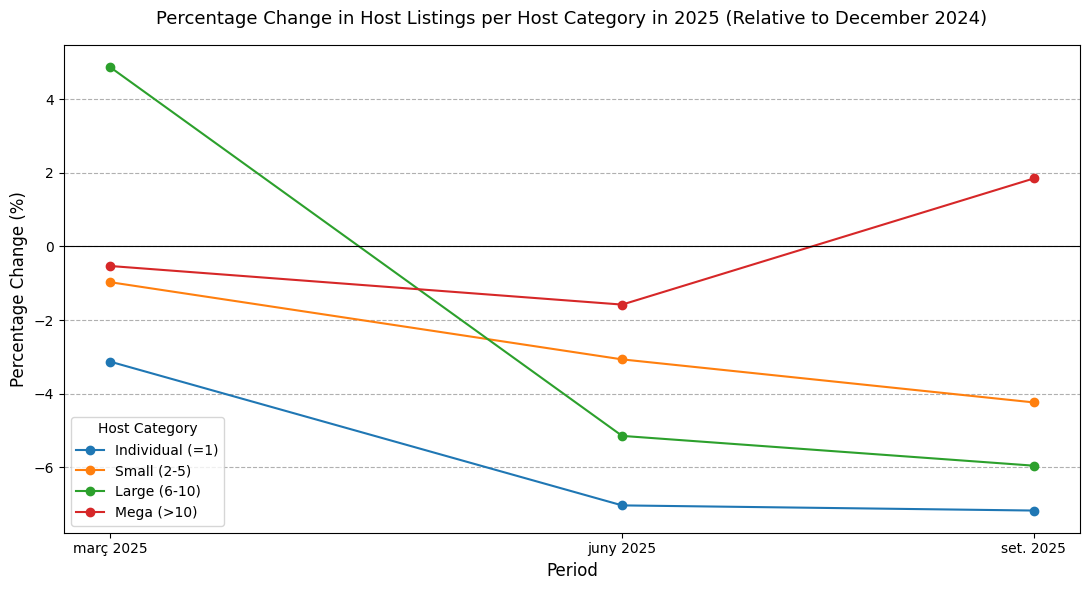

In [47]:
# We filter out the baseline (December 2024). We select all the rows starting from the row with index 1 (the second row), 
# .copy() makes sure we do not modify the original dataframe.
df_2025 = df_full_pct.iloc[1:].copy()

# We specify the size of the figure object we want to create.
plt.figure(figsize=(11, 6))

# Loop through each host category and plot a line with the value of the percentage change
# for each period, with a circle. label=col makes sure the legend will be correct.
for col in cols:
    plt.plot(df_2025['Period'], df_2025[col], marker='o', label=col)

# We define the title and the labels for the x and y-axes.
plt.title("Percentage Change in Host Listings per Host Category in 2025 (Relative to December 2024)", pad=15, fontsize=13)
plt.xlabel("Period",fontsize=12)
plt.ylabel("Percentage Change (%)", fontsize=12)

# We show the periods that we have data for in the x-axis formatted as ('Month Year') labels.
# .dt is the Pandas datetime accessor, strftime() formats datetime with a string,
# and '%b %Y' is the abbreviated month and the year.
dates = df_2025['Period']
date_labels = df_2025['Period'].dt.strftime('%b %Y')
plt.xticks(dates, date_labels)

# We add the title of the legend and locate it in the lower left corner.
plt.legend(title='Host Category', loc = 'lower left')
# We add discontinuous lines.
plt.grid(axis = 'y', linestyle = '--')
# We add a black line to represent the 0% percentage change with respect to December 2024.
plt.axhline(0, color='black', linestyle = '-', linewidth = 0.8)
# We make sure there are no elements overlapping.
plt.tight_layout()

# Finally, we save the graph in the reports folder with the name 'graph4.png'.
plt.savefig('../reports/graph3.png')